In [1]:
import matplotlib.pyplot as plt
from itertools import accumulate
from scipy.stats import norm
from statistics import mean,variance
from math import sqrt,log
import csv
import time

In [2]:
def split(f,g,R) :
    ra,rb = min(R),max(R)
    return min([(r,f(ra,r) + g(r,rb)) for r in R],key = lambda x : x[1])
    

In [3]:
def amoc(g,R,beta) :
    def f(i,j) : return 0 if i == j else g(i,j-1) + beta
    return split(f,g,R)
    

In [4]:
def op(g,R,beta,prune=False) :
    class functor :
        def __init__(self) :
            self.D = {}
        def add(self,x,y) :
            self.D[x] = y
        def __call__(self,*arg) :
            _,x = arg
            return self.D[x]
    f = functor()
    ra = min(R)
    T = []
    segmentation = {}
    cost = -beta
    for r in R :
        f.add(r,cost + beta)
        T.append(r)
        if prune :
            T = [t for t in T if f(ra,t) + g(t,r) <= f(ra,r) + beta]
        index,cost = split(f,g,T)
        segmentation[r] = (index,cost)
    return segmentation
    

In [5]:
def pelt(g,R,beta) :
    return op(g,R,beta,True)

In [6]:
def changepoints(segmentations) :
    ra = min(segmentations, key = segmentations.get)
    rb = max(segmentations, key = segmentations.get)
    index = rb
    locations = []
    while index != ra :
        index,_ = segmentations[index]
        locations.append(index)
    return locations

In [7]:
class sumstats :
    def __init__(self,X) :
        self.X = X
        self.SX = [0] + list(accumulate(X))
        self.SXX = [0] + list(accumulate([x*x for x in X]))

In [8]:
class normal_mean :
    def __init__(self,X) :
        self.sumstats = sumstats(X)
    def __call__(self,i,j) :
        val = self.sumstats.SX[j+1] - self.sumstats.SX[i]
        val *= val
        val /= (j - i + 1)
        val = -val
        val += self.sumstats.SXX[j+1] - self.sumstats.SXX[i]
        return val

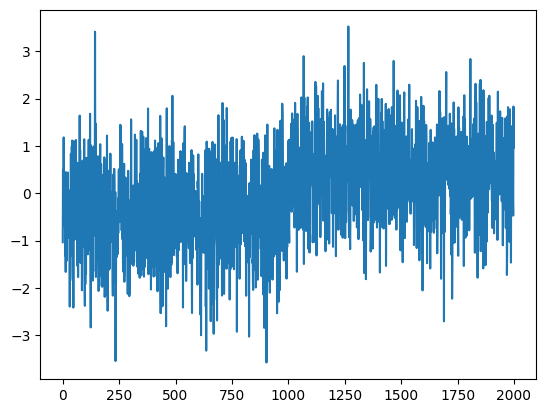

In [9]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] 
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z]
plt.plot(Z)
plt.show()

In [10]:
g = normal_mean(Z)
amoc(g,list(range(len(Z))),2*log(len(Z)))

(998, 1628.94901138994)

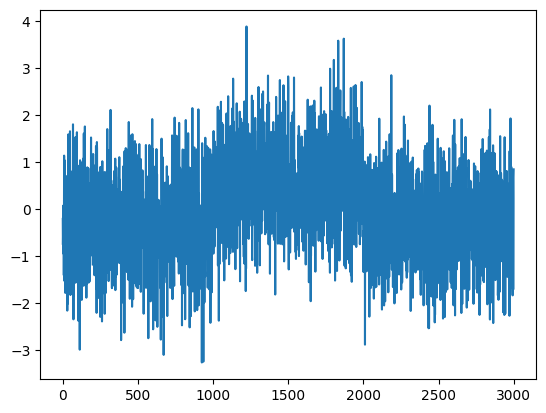

In [11]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] + [0.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z]
plt.plot(Z)
plt.show()

In [12]:
g = normal_mean(Z)
start =  time.perf_counter()
res = op(g,list(range(len(Z))),2*log(len(Z)))
end =  time.perf_counter()
print(changepoints(res))
print(end-start)

[2000, 998, 0]
3.640172417042777


In [13]:
g = normal_mean(Z)
start =  time.perf_counter()
res = pelt(g,list(range(len(Z))),2*log(len(Z)))
end =  time.perf_counter()
print(changepoints(res))
print(end-start)

[2000, 998, 0]
2.8215688010677695


In [14]:
file = open("X.csv", "r")
X = list(csv.reader(file, delimiter=","))
X = [float(item) for sublist in X for item in sublist]
file.close()
print(mean(X),sqrt(variance(X)))

-3.9863529867114243e-17 1.0


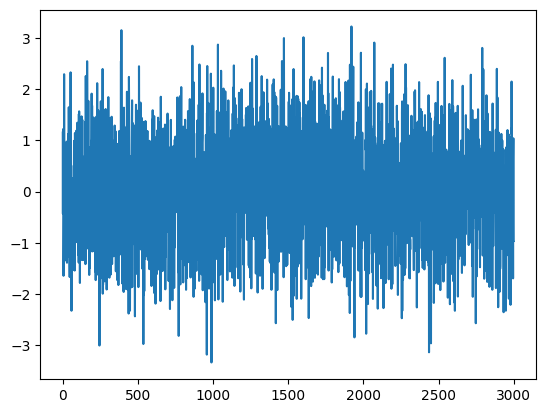

In [15]:
plt.plot(X)
plt.show()

In [16]:
g = normal_mean(X)
start =  time.perf_counter()
res = op(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[1933, 1025, 0]
2.945337292039767


In [17]:
g = normal_mean(X)
start =  time.perf_counter()
res = pelt(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[1933, 1025, 0]
4.655214222148061
